# LOADING LIBRARIES

In [ ]:
import pandas as pd
import admin
import numpy as np


# Import required libraries for RDD
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures

plt.style.use('default')
sns.set_palette("husl")

import pandas as pd
import admin
import rdd_describe

# DATA PROCESSING

In [ ]:
# FOR OPENING THE FILES, AVAILABLE IN GITHUB REPO, CHANGE THE PATHS ACCORDINGLY
# I WILL PUT THEM ALL INTO A FOLDER, SO YOU CAN JUST CHANGE THE PATH TO THAT FOLDER

# INSIDE FOLDER A
df1 = admin.read_csv_files(r"C:\Users\THW_9\Desktop\LSE School\Dis\REALIS DATA\2324")
df1 ['Street_Address'] = df1['Address'].str.split(' #').str[0]
df_street_address = df1.groupby('Street_Address').size().reset_index(name='count')
df_dist = pd.read_csv(r"C:\Users\THW_9\Desktop\LSE School\Dis\GIS\Historic\street_addresses_1846RD[increased2324].csv")

df_dist['Polygon'] = df_dist['Polygon'].fillna(0)
df_dist['signed_distance'] = df_dist['Distance'] * (df_dist['Polygon'] - 1)  # Create a new column for signed distance
df_dist.loc[df_dist['Polygon'] == 1, 'signed_distance'] = df_dist['Distance']
df_dist = df_dist.drop_duplicates(subset=['InputID'])
df2 = df_street_address.merge(df_dist, left_on='Street_Address', right_on='InputID', how='left')

# INSIDE FOLDER B
df_brit_towns = pd.read_csv(r"C:\Users\THW_9\Desktop\LSE School\Dis\GIS\UKtowns.csv")
df_brit_ppl = pd.read_csv(r"C:\Users\THW_9\Desktop\LSE School\Dis\GIS\colonialadmin.csv")

# INSIDE FOLDER C
df_MRTdist = pd.read_csv(r"C:\Users\THW_9\Desktop\LSE School\Dis\GIS\Historic\street_addresses_1846RD_reproject_MRTdist[2324].csv")
df_MRTdist = df_MRTdist.groupby('InputID', as_index=False).agg({'Distance': 'min'})
df_MRTdist = df_MRTdist.rename(columns={'Distance': 'MRT_Distance'})

df2 = df2.merge(df_MRTdist, left_on='InputID', right_on='InputID', how='left')
df1 = df1.merge(df2, left_on='Street_Address', right_on='Street_Address', how='left')
df1 = df1.dropna(subset=['MRT_Distance', 'signed_distance'])



In [6]:
df1['Unit Price ($ PSM)'] = df1['Unit Price ($ PSM)'].replace({'\$': '', ',': ''}, regex=True).astype(float)
df1['Area (SQM)'] = df1['Area (SQM)'].replace({'\$': '', ',': ''}, regex=True).astype(float)

# Remove rows with missing key variables
rdd_data = df1.dropna(subset=['Unit Price ($ PSM)', 'signed_distance', 'Polygon', 'MRT_Distance', 'Area (SQM)', 'Property Type', 'Completion Date']).copy().reset_index()

# Create treatment variable (1 if inside historic boundary, 0 if outside)
rdd_data['treatment'] = (rdd_data['Polygon'] == 1).astype(int)

# Log transform the price for better model fit
rdd_data['log_price'] = np.log(rdd_data['Unit Price ($ PSM)'])


# for running variable, which is distance to boundary
rdd_data['distance'] = rdd_data['signed_distance']

# for CONTROLS 

rdd_data['sale_date'] = df1['Sale Date'].str[3:] #date
rdd_data['sale_year'] = rdd_data['Sale Date'].str[7:] #year
rdd_data['area'] = rdd_data['Area (SQM)'] #area

rdd_data['reclaimed'] = rdd_data['Street_Address'].apply(lambda x: 1 if any(keyword in x for keyword in ['MARINA', 'SHENTON', 'RHU']) else 0)
rdd_data['landed'] = rdd_data['Property Type'].apply(lambda x: 1 if x in ['Terrace House', 'Semi-Detached House', 'Detached House'] else 0)

for i in range(0,len(rdd_data)):
    if rdd_data.at[i,'Completion Date'] == 'Uncompleted':
        rdd_data.at[i,'Completion Date'] = 2024
    elif rdd_data.at[i,'Completion Date'] == '-': # remove this data
        rdd_data = rdd_data.drop(i)
    elif isinstance(rdd_data.at[i,'Completion Date'], str):
        rdd_data.at[i,'Completion Date'] = int(rdd_data.at[i,'Completion Date'])
rdd_data['building_age'] = 2024 - rdd_data['Completion Date']
rdd_data['building_age'] = rdd_data['building_age'].astype(int)

# data preparation for toponymy
town_list = df_brit_towns['Towns'].tolist()
admin_list = df_brit_ppl['Administrator'].tolist()
admin_list = [name.replace(' (colonial administrator)', '') for name in admin_list]
admin_list = [name.split()[-1] for name in admin_list]

df_try = df_street_address.copy()

british_syllabary = town_list #change this to the list of British names 

df_try['british_name'] = 0
to_remove_list = ['Lew', 'Street', 'Lane', 'Rise', 'Heights', 'Grove', 'Seaview', 'Westwood', 'Field', 'Cross', 'Way', 'Link', 'Bay', 'Hill', 'Vale', 'How', 'Link', 'Tay', 'Chew', 'Woodlands', 'Rhu', 'Boon', 'Lake', 'Grove', 'East Street', 'Bay', 'Old', 'Heights', 'Central', 'Bow', 'Thong', 'Java', 'Lye', 'Lee', 'Cove', 'Plains', 'Ridge', 'Tong']
british_syllabary = [name for name in british_syllabary if name not in to_remove_list]

import re

# for NAME variable which is predictor variable
pattern = r'\b(?:' + '|'.join([re.escape(name.upper()) for name in british_syllabary]) + r')\b'
df_try['Street_Address_upper'] = df_try['Street_Address'].str.upper()
df_try['matched_name'] = df_try['Street_Address_upper'].str.findall(pattern)
df_try['matched_name'] = df_try['matched_name'].apply(lambda x: x if isinstance(x, list) else [])
df_try['british_name'] = df_try['matched_name'].apply(lambda x: int(len(x) > 0))

# merge back the df_try to rdd_data by 'Street_Address'
rdd_data = rdd_data.merge(df_try[['Street_Address', 'british_name']],
                          left_on='Street_Address', right_on='Street_Address', how='left')

<>:1: SyntaxWarning: invalid escape sequence '\$'
<>:2: SyntaxWarning: invalid escape sequence '\$'
<>:1: SyntaxWarning: invalid escape sequence '\$'
<>:2: SyntaxWarning: invalid escape sequence '\$'
C:\Users\THW_9\AppData\Local\Temp\ipykernel_1460\4285731622.py:1: SyntaxWarning: invalid escape sequence '\$'
  df1['Unit Price ($ PSM)'] = df1['Unit Price ($ PSM)'].replace({'\$': '', ',': ''}, regex=True).astype(float)
C:\Users\THW_9\AppData\Local\Temp\ipykernel_1460\4285731622.py:2: SyntaxWarning: invalid escape sequence '\$'
  df1['Area (SQM)'] = df1['Area (SQM)'].replace({'\$': '', ',': ''}, regex=True).astype(float)


 # MODEL FOR RDD, FOR "TRUE" HERITAGE

In [8]:
# Choose a bandwidth , for global, just specify a really huge bandwidth
bandwidth = 100
rdd_sample = rdd_data[abs(rdd_data['distance']) <= bandwidth]
rdd_sample['distance_sq'] = rdd_sample['distance'] ** 2 # if u want to try with polynomial

# TREATMENT STANDS FOR THE COLONIAL TOWN, WHERE 0 IS OUTSIDE AND 1 IS INSIDE
# DISTANCEC IS THE DISTANCE TO THE BOUNDARY, <0 is outside and >0 is inside

model = smf.ols('log_price ~ treatment + distance + landed + building_age + MRT_Distance + sale_year', data=rdd_sample).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     169.3
Date:                Fri, 01 Aug 2025   Prob (F-statistic):          2.32e-120
Time:                        00:26:18   Log-Likelihood:                 210.60
No. Observations:                 544   AIC:                            -407.2
Df Residuals:                     537   BIC:                            -377.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            10.2209      0.03

C:\Users\THW_9\AppData\Local\Temp\ipykernel_1460\457530638.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_sample['distance_sq'] = rdd_sample['distance'] ** 2 # if u want to try with polynomial


c:\Users\THW_9\Desktop\LSE School\Dis\Python\Thesis-Colonial-Premium\rdd_describe.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  axes[1,0].hist(rdd_sample[rdd_data['treatment']==0]['distance'],
c:\Users\THW_9\Desktop\LSE School\Dis\Python\Thesis-Colonial-Premium\rdd_describe.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  axes[1,0].hist(rdd_sample[rdd_data['treatment']==1]['distance'],


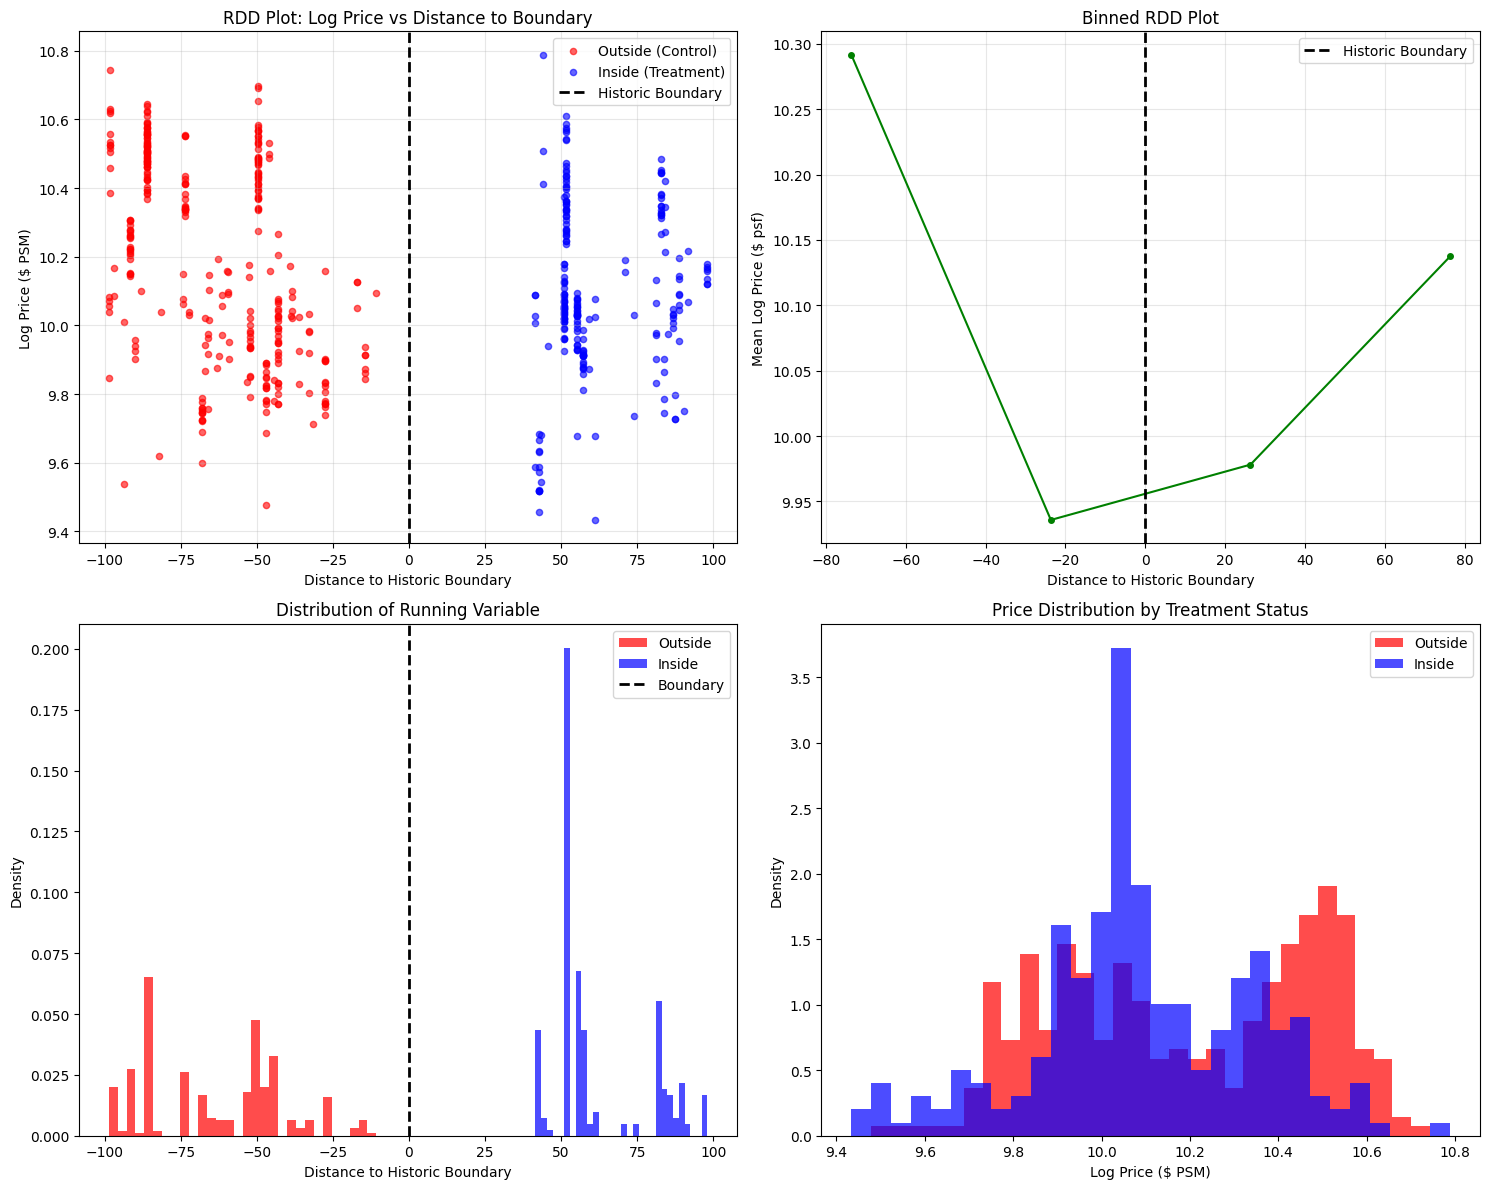

Sample size: 544
Treatment group (inside): 220
Control group (outside): 324
Distance range: -98.66 to 98.09

Summary Statistics by Treatment Status:
          log_price                                                      \
              count       mean       std       min       25%        50%   
treatment                                                                 
0             324.0  10.192935  0.293385  9.477922  9.934877  10.194103   
1             220.0  10.091051  0.246477  9.433484  9.960730  10.058224   

                                Unit Price ($ PSM)                ...  \
                 75%        max              count          mean  ...   
treatment                                                         ...   
0          10.475491  10.742832              324.0  27858.080247  ...   
1          10.278734  10.788969              220.0  24858.345455  ...   

                             distance                                   \
                75%      max    cou

In [9]:
rdd_describe.describe(rdd_data, 100)

# MODEL FOR FAKE HERITAGE

In [10]:
# Choose a bandwidth , for global, just specify a really huge bandwidth
bandwidth = 100
rdd_sample = rdd_data[abs(rdd_data['distance']) <= bandwidth]

rdd_sample['treatment_prime'] = 1 - rdd_sample['treatment'] # to inverse the colonial town 
rdd_sample['distance_sq'] = rdd_sample['distance'] ** 2 # if u want to try with polynomial

model = smf.ols('log_price ~ treatment_prime + british_name + distance + landed + building_age + MRT_Distance + sale_year', data=rdd_sample).fit()

from IPython.display import display

display(model.summary())

C:\Users\THW_9\AppData\Local\Temp\ipykernel_1460\3958276646.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_sample['treatment_prime'] = 1 - rdd_sample['treatment'] # to inverse the colonial town
C:\Users\THW_9\AppData\Local\Temp\ipykernel_1460\3958276646.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_sample['distance_sq'] = rdd_sample['distance'] ** 2 # if u want to try with polynomial


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     147.9
Date:                Fri, 01 Aug 2025   Prob (F-statistic):          8.46e-121
Time:                        00:26:41   Log-Likelihood:                 214.29
No. Observations:                 544   AIC:                            -412.6
Df Residuals:                     536   BIC:                            -378.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            10.3677      0.026    392.505      0.000      10.316      10.420
sale_year[T.2024]     0.0012      0.014      0.084      0.933      -0.027       0.029
treatment_prime      -0.1249      0.051     -2.470      0.014      -0.224      -0.026
british_name         -0.0421      0.016     -2.706      0.007      -0.073      -0.012
distance             -0.0016      0.000     -4.323      0.000      -0.002      -0.001
landed                0.3376      0.098      3.452      0.001       0.146       0.530
building_age         -0.0202      0.001    -26.598      0.000      -0.022      -0.019
MRT_Distance          0.0002   4.51e-05      3.820      0.000    8.36e-05       0.000
==============================================================================
Omnibus:                       15.023   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.390
Skew:                           0.348   Prob(JB):                     0.000276
Kurtosis:                       3.488   Cond. No.                     5.32e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.32e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
# Choose a bandwidth , for global, just specify a really huge bandwidth
bandwidth = 10000000
rdd_sample = rdd_data[abs(rdd_data['distance']) <= bandwidth]

rdd_sample['treatment_prime'] = 1 - rdd_sample['treatment'] # to inverse the colonial town 
rdd_sample['distance_sq'] = rdd_sample['distance'] ** 2 # if u want to try with polynomial

model = smf.ols('log_price ~ treatment_prime + british_name + british_name*treatment_prime + distance + landed + building_age + MRT_Distance + sale_date', data=rdd_sample).fit()

from IPython.display import display

display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     2628.
Date:                Fri, 01 Aug 2025   Prob (F-statistic):               0.00
Time:                        00:26:45   Log-Likelihood:                 11299.
No. Observations:               45703   AIC:                        -2.254e+04
Df Residuals:                   45672   BIC:                        -2.226e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       10.2946      0.007   1391.502      0.000      10.280      10.309
sale_date[T.Apr 2024]            0.0150      0.006      2.534      0.011       0.003       0.027
sale_date[T.Aug 2023]           -0.0113      0.006     -1.894      0.058      -0.023       0.000
sale_date[T.Aug 2024]            0.0094      0.006      1.528      0.127      -0.003       0.021
sale_date[T.Dec 2023]           -0.0129      0.007     -1.908      0.056      -0.026       0.000
sale_date[T.Dec 2024]            0.0331      0.006      5.347      0.000       0.021       0.045
sale_date[T.Feb 2023]           -0.0183      0.007     -2.807      0.005      -0.031      -0.006
sale_date[T.Feb 2024]           -0.0061      0.007     -0.897      0.370      -0.019       0.007
sale_date[T.Jan 2023]           -0.0152      0.007     -2.210      0.027      -0.029      -0.002
sale_date[T.Jan 2024]           -0.0061      0.006     -0.982      0.326      -0.018       0.006
sale_date[T.Jul 2023]            0.0285      0.006      5.136      0.000       0.018       0.039
sale_date[T.Jul 2024]            0.0550      0.006      9.402      0.000       0.044       0.066
sale_date[T.Jun 2023]           -0.0474      0.006     -7.337      0.000      -0.060      -0.035
sale_date[T.Jun 2024]            0.0124      0.006      1.941      0.052      -0.000       0.025
sale_date[T.Mar 2023]           -0.0228      0.006     -3.828      0.000      -0.034      -0.011
sale_date[T.Mar 2024]            0.0387      0.006      6.622      0.000       0.027       0.050
sale_date[T.May 2023]            0.0276      0.006      4.891      0.000       0.017       0.039
sale_date[T.May 2024]            0.0009      0.006      0.142      0.887      -0.011       0.013
sale_date[T.Nov 2023]            0.0685      0.006     11.535      0.000       0.057       0.080
sale_date[T.Nov 2024]            0.1112      0.005     21.943      0.000       0.101       0.121
sale_date[T.Oct 2023]           -0.0148      0.006     -2.304      0.021      -0.027      -0.002
sale_date[T.Oct 2024]            0.0880      0.006     15.231      0.000       0.077       0.099
sale_date[T.Sep 2023]           -0.0251      0.007     -3.855      0.000      -0.038      -0.012
sale_date[T.Sep 2024]            0.0356      0.006      5.880      0.000       0.024       0.047
treatment_prime                 -0.0123      0.006     -1.922      0.055      -0.025       0.000
british_name                     0.0402      0.009      4.252      0.000       0.022       0.059
british_name:treatment_prime    -0.0213      0.010     -2.138      0.033      -0.041      -0.002
distance                      4.539e-05   2.55e-07    177.939      0.000    4.49e-05    4.59e-05
landed                           0.1747      0.004     41.341      0.000    